<a href="https://colab.research.google.com/github/Shihab7u/Brain-Tumor-Detection-and-Classification/blob/main/CovBi_GRU-(Dataset_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1SF24UZbOh9oCOnhc_NAo9aQtVAA-vtwl/view?usp=share_link

Downloading...
From: https://drive.google.com/uc?id=1SF24UZbOh9oCOnhc_NAo9aQtVAA-vtwl
To: /content/Brain_Image_Data.zip
100% 91.0M/91.0M [00:00<00:00, 172MB/s]


In [ ]:
!unzip "/content/Brain_Image_Data.zip" > /dev/null

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers import Input

In [ ]:
import os

path = os.listdir('/content/Training/')
classes = {'no_tumor':0, 'pituitary_tumor':1, 'glioma_tumor':2, 'meningioma_tumor': 3}

In [ ]:
import cv2
X = []
Y = []
for cls in classes:
    pth1 = '/content/Training/'+cls
    for j in os.listdir(pth1):
        img = cv2.imread(pth1+'/'+j, 0)
        img = cv2.resize(img, (224,224))
        X.append(img)
        Y.append(classes[cls])

    pth2 = '/content/Testing/'+cls
    for j in os.listdir(pth2):
        img = cv2.imread(pth2+'/'+j, 0)
        img = cv2.resize(img, (224,224))
        X.append(img)
        Y.append(classes[cls])

In [ ]:
X = np.array(X)
Y = np.array(Y)

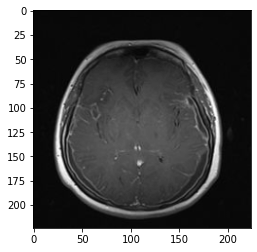

In [ ]:
plt.imshow(X[0], cmap='gray')

In [ ]:
X[0].shape

(224, 224)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=10,
                                               test_size=.20)

In [ ]:
xtrain.shape, xtest.shape

((2611, 224, 224), (653, 224, 224))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

In [ ]:
def preprocessingImages1(path):
  """
  input : path
  output : preprocessed image
  """
  image_data = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, preprocessing_function = preprocess_input, horizontal_flip = True) # data agumentation, zoom range = 0.2, shear_range = 0.2
  image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode = 'categorical') #batch size

  return image

In [ ]:
path = "/content/Testing/"
train_data = preprocessingImages1(path)

Found 394 images belonging to 4 classes.


In [ ]:
def preprocessingImages2(path):
  """
  input : path
  output : preprocessed image
  """
  image_data = ImageDataGenerator(preprocessing_function = preprocess_input)
  image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode = 'categorical')

  return image

In [ ]:
path = "/content/Testing/"
test_data =  preprocessingImages2(path)

Found 394 images belonging to 4 classes.


In [ ]:
#Model building starts
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input,Bidirectional,LSTM,Lambda, GRU
from tensorflow.keras.layers import Permute,GlobalMaxPool1D,Concatenate, Dense, BatchNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Activation, Flatten,MaxPooling1D,Conv1D, Conv2D,MaxPool2D

In [ ]:
model = Sequential()
model.add(Conv1D(64, 4, activation='relu', input_shape = (224,224))) #3 Conv1D
model.add(MaxPooling1D(pool_size=2)) #2
model.add(BatchNormalization())


model.add(Bidirectional(GRU(64, return_sequences=True)))

model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())



model.add(Bidirectional(GRU(128, return_sequences=True)))


model.add(Conv1D(128, 2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())






model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, activation='softmax'))

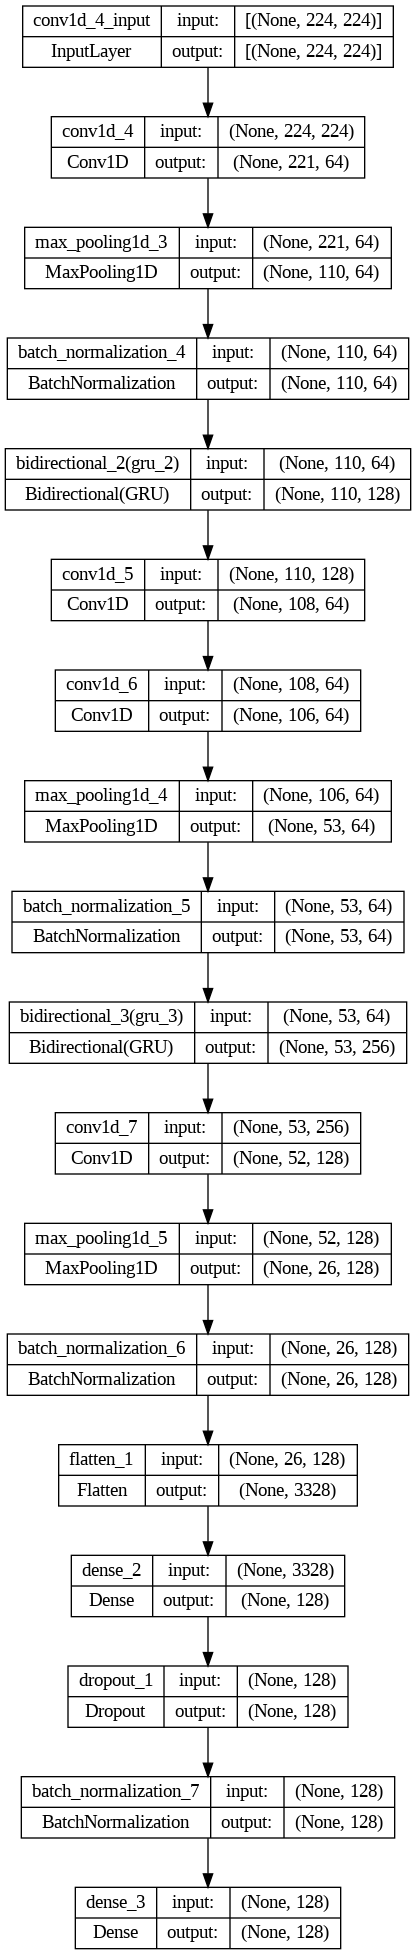

In [ ]:
# plot model architecture
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='CNN + Bi-GRU Architecture.png')

In [ ]:
 model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 221, 64)           57408     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 110, 64)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 110, 64)          256       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 110, 128)         49920     
 l)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 108, 64)           24640     
                                                        

In [ ]:
model.compile(optimizer='Adam',
            loss='sparse_categorical_crossentropy',
             metrics=["accuracy"])

In [ ]:
r = model.fit(xtrain, ytrain, epochs=80,validation_data=(xtest,ytest), batch_size=32)

Epoch 1/80
82/82 [==============================] - 26s 49ms/step - loss: 2.1894 - accuracy: 0.6212 - val_loss: 3.3904 - val_accuracy: 0.2496
Epoch 2/80
82/82 [==============================] - 2s 24ms/step - loss: 0.9633 - accuracy: 0.7660 - val_loss: 1.7367 - val_accuracy: 0.4364
Epoch 3/80
82/82 [==============================] - 2s 22ms/step - loss: 0.6430 - accuracy: 0.8012 - val_loss: 3.1831 - val_accuracy: 0.3492
Epoch 4/80
82/82 [==============================] - 2s 26ms/step - loss: 0.5027 - accuracy: 0.8384 - val_loss: 0.6737 - val_accuracy: 0.7596
Epoch 5/80
82/82 [==============================] - 2s 27ms/step - loss: 0.3638 - accuracy: 0.8774 - val_loss: 0.8100 - val_accuracy: 0.7611
Epoch 6/80
82/82 [==============================] - 2s 22ms/step - loss: 0.2797 - accuracy: 0.8962 - val_loss: 0.6351 - val_accuracy: 0.7764
Epoch 7/80
82/82 [==============================] - 2s 23ms/step - loss: 0.2123 - accuracy: 0.9268 - val_loss: 0.5764 - val_accuracy: 0.8224
Epoch 8/80
8

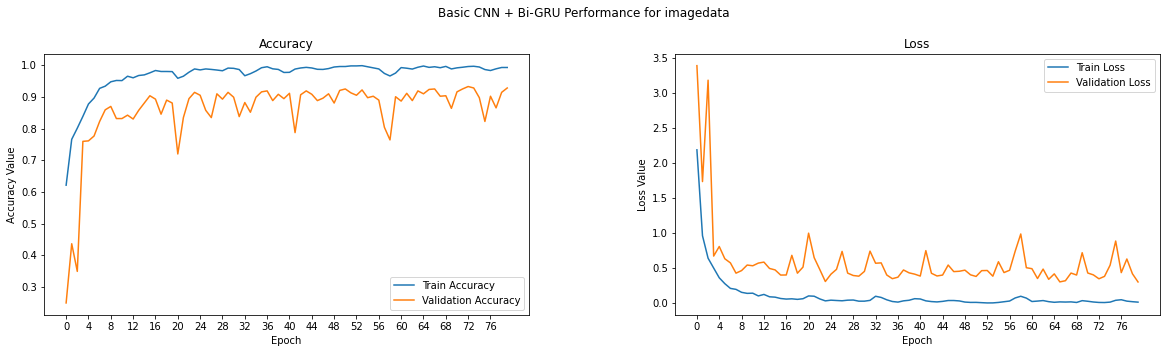

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
t = f.suptitle('Basic CNN + Bi-GRU Performance for imagedata', fontsize=12 )
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,80))
ax1.plot(epoch_list, r.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, r.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 80, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, r.history['loss'], label='Train Loss')
ax2.plot(epoch_list, r.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 80, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


plt.savefig('CNN + Bi-GRU Performance imagedata.png')

In [ ]:
pred=model.predict(xtest)
Y_pred = np.argmax(pred, 1)

21/21 [==============================] - 1s 13ms/step


In [ ]:
Y_pred.shape

(653,)

In [ ]:
ytest.shape

(653,)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(ytest, Y_pred))

Confusion Matrix
[[ 94   0   4   5]
 [  1 193   1   0]
 [  3   2 145  15]
 [  7   2   7 174]]


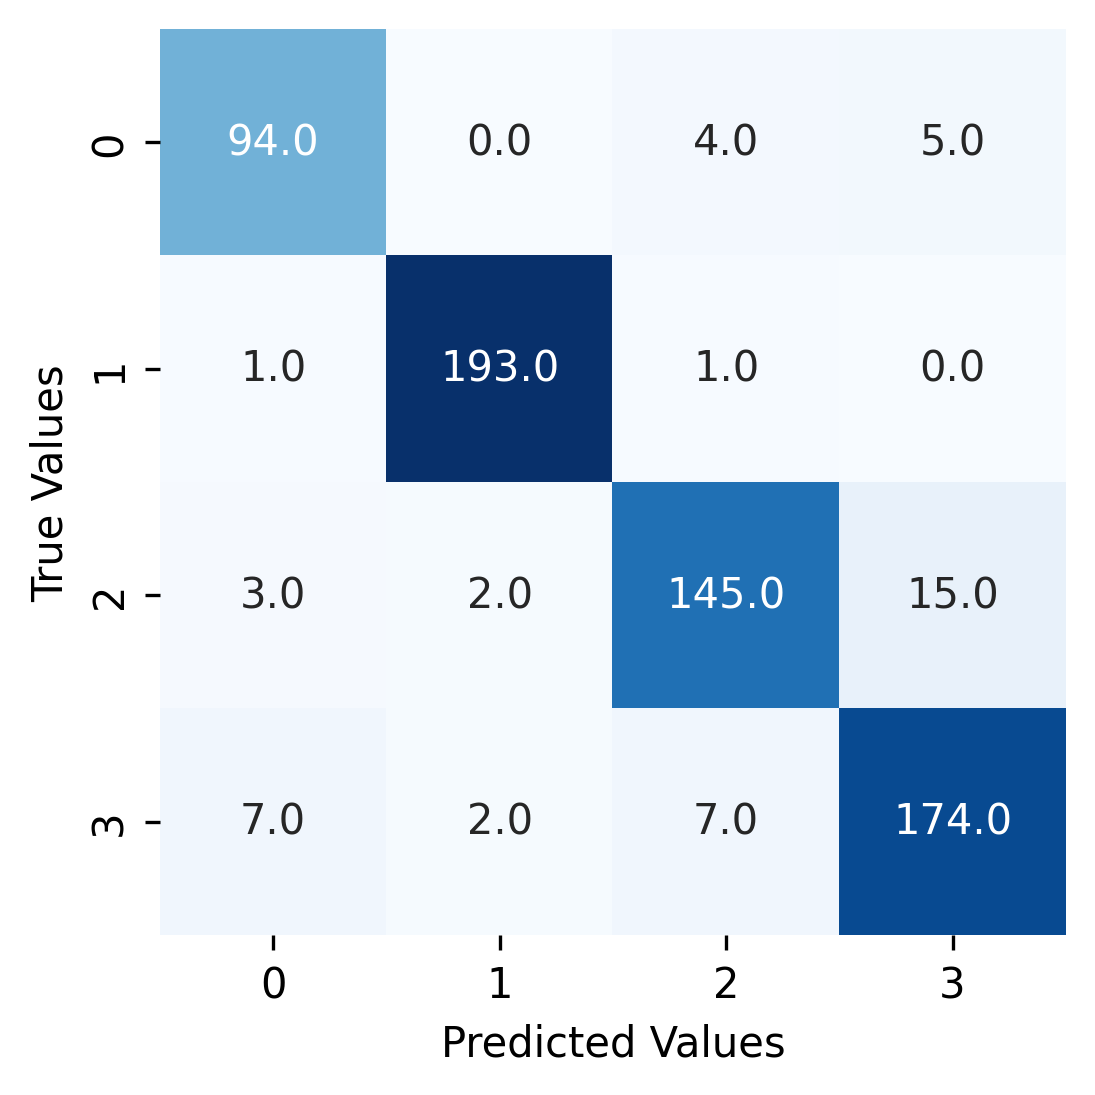

In [ ]:
import seaborn as sns
cm=confusion_matrix(ytest, Y_pred)
plt.figure(dpi=300),sns.heatmap(cm, square=True, annot=True, fmt=".1f", cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');

In [ ]:
print('Classification Report')
target_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
print(classification_report(ytest, Y_pred, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.91      0.90       103
meningioma_tumor       0.98      0.99      0.98       195
        no_tumor       0.92      0.88      0.90       165
 pituitary_tumor       0.90      0.92      0.91       190

        accuracy                           0.93       653
       macro avg       0.92      0.92      0.92       653
    weighted avg       0.93      0.93      0.93       653



In [ ]:
print(ytrain)

[3 3 0 ... 1 3 1]


[Text(0, 0.5, 'glioma'),
 Text(0, 1.5, 'meningioma'),
 Text(0, 2.5, 'no_tumor'),
 Text(0, 3.5, 'pituitary')]

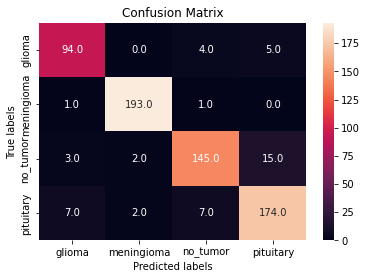

<Figure size 1800x1200 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


ax= plt.subplot()
plt.figure(dpi=300),sns.heatmap(cm, annot=True, ax = ax, fmt=".1f"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['glioma', 'meningioma', 'no_tumor', 'pituitary']); ax.yaxis.set_ticklabels(['glioma', 'meningioma', 'no_tumor', 'pituitary'])

Confusion Matrix :
[[ 94   0   4   5]
 [  1 193   1   0]
 [  3   2 145  15]
 [  7   2   7 174]]
Accuracy Score : 0.9280245022970903
Report : 
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       103
           1       0.98      0.99      0.98       195
           2       0.92      0.88      0.90       165
           3       0.90      0.92      0.91       190

    accuracy                           0.93       653
   macro avg       0.92      0.92      0.92       653
weighted avg       0.93      0.93      0.93       653



(<Figure size 1800x1200 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f30d7077160>)

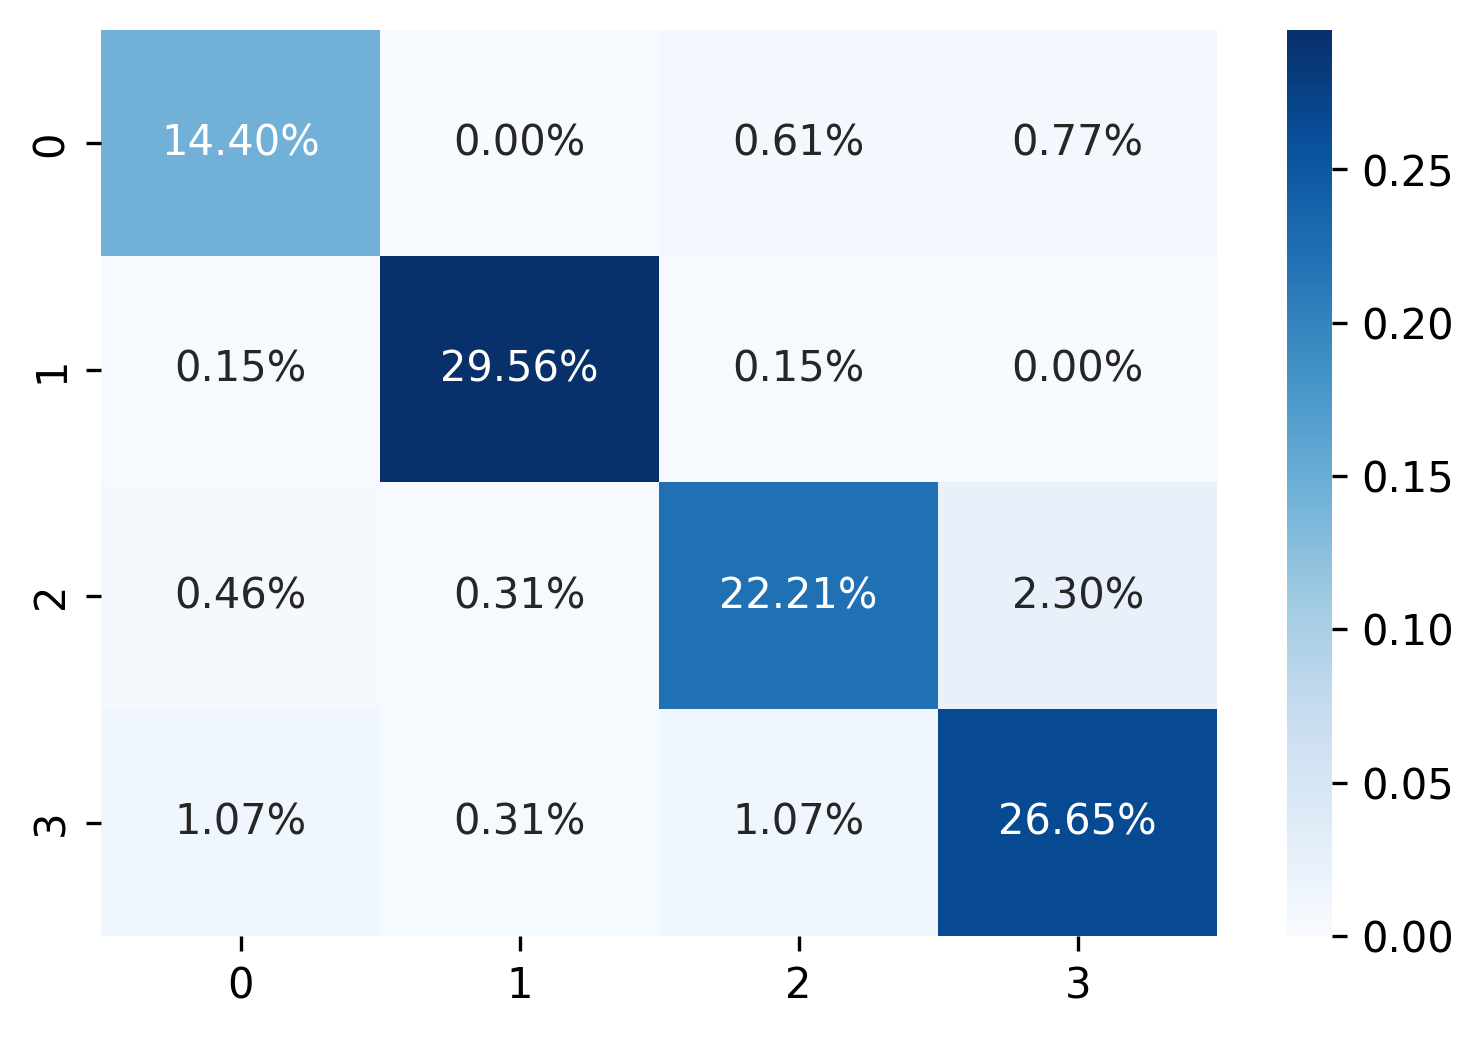

In [ ]:
from sklearn.metrics import accuracy_score
results = confusion_matrix(ytest,Y_pred)
print('Confusion Matrix :')
print(results)
print('Accuracy Score :',accuracy_score(ytest,Y_pred))
print('Report : ')
print(classification_report(ytest,Y_pred))

plt.figure(dpi=300),sns.heatmap(results/np.sum(results), annot=True,
            fmt='.2%', cmap='Blues')

In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(ytest, Y_pred, pos_label=2)
metrics.auc(fpr, tpr)

0.6267324888226528

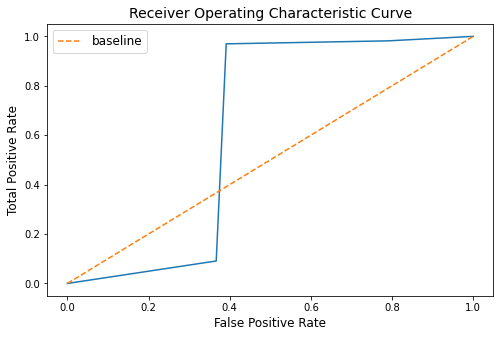

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr, tpr)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=14)
plt.ylabel('Total Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(fontsize=12);
